# Laboratorio 5 
### Parte 1 y 2

##### Ma. Isabel Ortiz Naranjo
##### Luis Urbina

## Parte 1

In [62]:
!pip install Scapy
from scapy.all import *
import pandas as pd 
import numpy as np 
import binascii
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import cross_val_score
from sklearn import metrics, model_selection, tree
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


%matplotlib inline


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Captura de 100 paquetes

In [ ]:
num_of_packets_to_sniff = 100
pcap = sniff(count = num_of_packets_to_sniff)
# rdpcap returns packet list
## packetlist object can be enumerated 
print("Tipo:", type(pcap))
print("Largo: ", len(pcap))
print(pcap)

Tipo: <class 'scapy.plist.PacketList'>
Largo:  100
<Sniffed: TCP:100 UDP:0 ICMP:0 Other:0>


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Lab 5/analisis_paquetes.pcap"

In [ ]:
arc = rdpcap(file_path)
print(file_path)

/content/drive/MyDrive/Colab Notebooks/Lab 5/analisis_paquetes.pcap


In [ ]:
pcap = pcap + arc
print(pcap)

<Sniffed+analisis_paquetes.pcap+analisis_paquetes.pcap+analisis_paquetes.pcap: TCP:100 UDP:186 ICMP:0 Other:0>


Conversion de PCAP a DF

In [ ]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head())

  version ihl tos   len     id flags frag ttl proto chksum  ... dataofs  \
0       4   5   0   894  63448    DF    0  64     6  59235  ...       8   
1       4   5   0    52  44447    DF    0  64     6  13543  ...       8   
2       4   5   0   648  10099    DF    0  64     6  47297  ...       8   
3       4   5   0    52  50808    DF    0  64     6   7184  ...       8   
4       4   5   0  1244  50809    DF    0  64     6   5991  ...       8   

  reserved flags window chksum urgptr options payload  \
0        0    PA    501  23470      0       3     842   
1        0     A   5832  22628      0       3       0   
2        0    PA    501  23222      0       3     596   
3        0     A    501  22626      0       3       0   
4        0    PA    501  23818      0       3    1192   

                                         payload_raw  \
0  b'\x81~\x03F{"header": {"msg_id": "77fdeb69-05...   
1                                                b''   
2  b'GET /socket.io/?EIO=3&sid=B7_a0lT

In [ ]:
# Return Src Address, Dst Address, Src Port, Dst Port
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,172.28.0.3,172.28.0.2,6000,43230
1,172.28.0.2,172.28.0.3,43230,6000
2,172.28.0.1,172.28.0.2,50128,8080
3,172.28.0.2,172.28.0.1,8080,50128
4,172.28.0.2,172.28.0.1,8080,50128
...,...,...,...,...
281,84.54.22.33,10.1.10.53,53,53
282,10.1.10.53,84.54.22.33,53,53
283,84.54.22.33,10.1.10.53,53,53
284,10.1.10.53,84.54.22.33,53,53


In [ ]:
# Estadisticas
print("# Top Source Address")
print(df['src'].describe(),'\n\n')
print(df['src'].describe()['top'])

# Top Source Address
count            286
unique             8
top       10.1.10.53
freq              93
Name: src, dtype: object 


10.1.10.53


In [ ]:
#¿Quien es la IP de origen mas frecuente?
frequent_address = df['src'].describe()['top']
print(frequent_address)
# A que IPs les habla la IP mas frecuente
print(df[df['src'] == frequent_address]['dst'].unique(),"\n\n")

10.1.10.53
['84.54.22.33' '75.75.75.75'] 




In [ ]:
df['dst'][df['src'] == frequent_address].value_counts()


84.54.22.33    87
75.75.75.75     6
Name: dst, dtype: int64

In [ ]:
df['dport'][df['src'] == frequent_address].value_counts()

53    93
Name: dport, dtype: int64

In [ ]:
df['sport'][df['src'] == frequent_address].value_counts()


53       87
15812     3
23903     3
Name: sport, dtype: int64

R//: Puerto 53

Puerto 53: Es utilizado para servicios DNS, este protocolo permite utilizar tanto TCP como UDP para la comunicación con los servidores DNS.

Fuente: https://www.redeszone.net/tutoriales/configuracion-puertos/puertos-tcp-udp/




AxesSubplot(0.125,0.125;0.775x0.755)


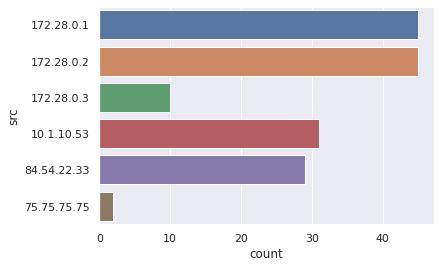

In [ ]:
# Graficas
# Grafica 1
grafica1 = sns.countplot(
    data = df,
    y = 'src',
)

print(grafica1)


AxesSubplot(0.125,0.125;0.775x0.755)


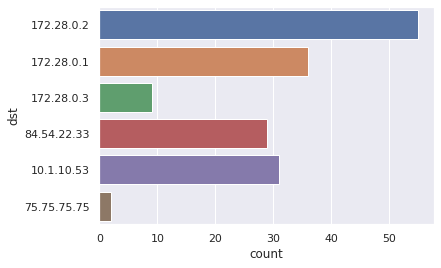

In [ ]:
# grafica 2
grafica2 = sns.countplot(
    data = df,
    y = 'dst',
)

print(grafica2)

AxesSubplot(0.125,0.125;0.775x0.755)


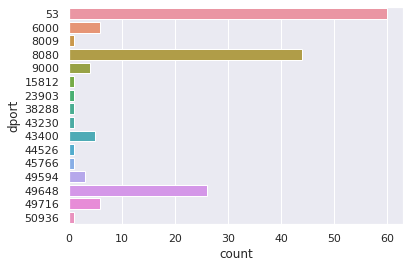

In [ ]:
# grafica 3

grafica3 = sns.countplot(
    data = df,
    y = 'dport',
)

print(grafica3)

AxesSubplot(0.125,0.125;0.775x0.755)


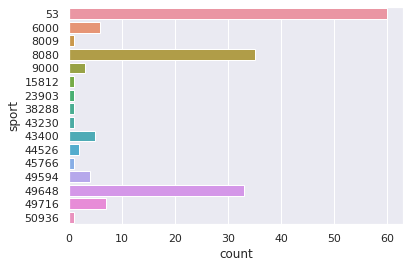

In [ ]:
# grafica 4
grafica4 = sns.countplot(
    data = df,
    y = 'sport',
)

print(grafica4)

In [ ]:
# Investigacion del payload
top = df[df['src'] == frequent_address]
top

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,648,55723,DF,0,64,6,1673,...,8,0,PA,501,23222,0,3,596,b'GET /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcAA...,b'474554202f736f636b65742e696f2f3f45494f3d3326...
3,4,5,0,52,55724,DF,0,64,6,2268,...,8,0,A,500,22626,0,3,0,b'',b''
4,4,5,0,754,55725,DF,0,64,6,1565,...,8,0,PA,501,23328,0,3,702,b'POST /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcA...,b'504f5354202f736f636b65742e696f2f3f45494f3d33...
6,4,5,0,4396,55726,DF,0,64,6,63457,...,8,0,PA,501,26970,0,3,4344,"b'98:42/python-lsp/1,[""data"",{""data"":""{\\""meth...",b'39383a34322f707974686f6e2d6c73702f312c5b2264...
8,4,5,0,2144,55729,DF,0,64,6,171,...,8,0,PA,501,24718,0,3,2092,b'as frecuente?\\\\nfrequent_address = df[\'sr...,b'6173206672656375656e74653f5c5c6e667265717565...
11,4,5,0,52,55731,DF,0,64,6,2261,...,8,0,A,501,22626,0,3,0,b'',b''
14,4,5,0,648,55732,DF,0,64,6,1664,...,8,0,PA,501,23222,0,3,596,b'GET /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcAA...,b'474554202f736f636b65742e696f2f3f45494f3d3326...
17,4,5,0,52,55733,DF,0,64,6,2259,...,8,0,A,490,22626,0,3,0,b'',b''
18,4,5,0,753,55734,DF,0,64,6,1557,...,8,0,PA,501,23327,0,3,701,b'POST /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcA...,b'504f5354202f736f636b65742e696f2f3f45494f3d33...
19,4,5,0,878,55735,DF,0,64,6,1431,...,8,0,PA,501,23452,0,3,826,"b'\x00\x05\x02\xff451-/debugger,[""data"",{""_pla...",b'000502ff3435312d2f64656275676765722c5b226461...


In [ ]:
df_top = top['dst'].unique()

In [ ]:
top['dst'].value_counts()

whq = df_top[0]
print(whq)

172.28.0.2


In [ ]:
nw = top[top["dst"]== whq]
nw

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,648,55723,DF,0,64,6,1673,...,8,0,PA,501,23222,0,3,596,b'GET /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcAA...,b'474554202f736f636b65742e696f2f3f45494f3d3326...
3,4,5,0,52,55724,DF,0,64,6,2268,...,8,0,A,500,22626,0,3,0,b'',b''
4,4,5,0,754,55725,DF,0,64,6,1565,...,8,0,PA,501,23328,0,3,702,b'POST /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcA...,b'504f5354202f736f636b65742e696f2f3f45494f3d33...
6,4,5,0,4396,55726,DF,0,64,6,63457,...,8,0,PA,501,26970,0,3,4344,"b'98:42/python-lsp/1,[""data"",{""data"":""{\\""meth...",b'39383a34322f707974686f6e2d6c73702f312c5b2264...
8,4,5,0,2144,55729,DF,0,64,6,171,...,8,0,PA,501,24718,0,3,2092,b'as frecuente?\\\\nfrequent_address = df[\'sr...,b'6173206672656375656e74653f5c5c6e667265717565...
11,4,5,0,52,55731,DF,0,64,6,2261,...,8,0,A,501,22626,0,3,0,b'',b''
14,4,5,0,648,55732,DF,0,64,6,1664,...,8,0,PA,501,23222,0,3,596,b'GET /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcAA...,b'474554202f736f636b65742e696f2f3f45494f3d3326...
17,4,5,0,52,55733,DF,0,64,6,2259,...,8,0,A,490,22626,0,3,0,b'',b''
18,4,5,0,753,55734,DF,0,64,6,1557,...,8,0,PA,501,23327,0,3,701,b'POST /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcA...,b'504f5354202f736f636b65742e696f2f3f45494f3d33...
19,4,5,0,878,55735,DF,0,64,6,1431,...,8,0,PA,501,23452,0,3,826,"b'\x00\x05\x02\xff451-/debugger,[""data"",{""_pla...",b'000502ff3435312d2f64656275676765722c5b226461...


In [ ]:
arregloNuevo = nw['payload_raw'].to_numpy()
for i in arregloNuevo:
    print(i,"\n\n")

b'GET /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcAAAC&t=O0c7gol&transport=polling HTTP/1.1\r\nHost: colab.research.google.com\r\nUser-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36,gzip(gfe)\r\nAccept: */*\r\nAccept-Encoding: gzip, deflate, br,gzip(gfe)\r\nAccept-Language: en-US,en;q=0.9,es;q=0.8\r\nReferer: https://colab.research.google.com/\r\nSec-Ch-Ua: " Not;A Brand";v="99", "Google Chrome";v="97", "Chromium";v="97"\r\nSec-Ch-Ua-Mobile: ?0\r\nSec-Ch-Ua-Platform: "Linux"\r\nSec-Fetch-Dest: empty\r\nSec-Fetch-Mode: cors\r\nSec-Fetch-Site: same-origin\r\n\r\n' 


b'' 


b'POST /socket.io/?EIO=3&sid=B7_a0lTRetUv-ZmcAAAC&t=O0c7gon&transport=polling HTTP/1.1\r\nHost: colab.research.google.com\r\nUser-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36,gzip(gfe)\r\nContent-Length: 6436\r\nAccept: */*\r\nAccept-Encoding: gzip, deflate, br,gzip(gfe)\r\nAccept-Language: en-

Respuesta: 

Examinando el contenido, se encuentra una anomalia con un archivo png. 


# Parte 2

In [ ]:
part2df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab 5/Train_data.csv")

In [ ]:
part2df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
part2df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
# Preprocesamiento
enco = LabelEncoder()
part2df["class"]= enco.fit_transform(part2df["class"])
arr = part2df['class']
finaldf = part2df.drop(columns=['class'])
arr




0        1
1        1
2        0
3        1
4        1
        ..
25187    0
25188    0
25189    0
25190    0
25191    0
Name: class, Length: 25192, dtype: int64

In [ ]:
cat = part2df.select_dtypes(exclude=[np.number])
for col in cat:
    print(cat[col].value_counts())


tcp     20526
udp      3011
icmp     1655
Name: protocol_type, dtype: int64
http         8003
private      4351
domain_u     1820
smtp         1449
ftp_data     1396
             ... 
urh_i           4
red_i           3
pm_dump         3
tim_i           2
http_8001       1
Name: service, Length: 66, dtype: int64
SF        14973
S0         7009
REJ        2216
RSTR        497
RSTO        304
S1           88
SH           43
RSTOS0       21
S2           21
S3           15
OTH           5
Name: flag, dtype: int64


In [ ]:
one = OneHotEncoder(handle_unknown='ignore')
cta = pd.DataFrame(one.fit_transform(part2df[list(cat.columns)]).toarray())
cta

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25188,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25189,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25190,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in cta.columns:
    print(cta[col].value_counts())

0.0    23537
1.0     1655
Name: 0, dtype: int64
1.0    20526
0.0     4666
Name: 1, dtype: int64
0.0    22181
1.0     3011
Name: 2, dtype: int64
0.0    25152
1.0       40
Name: 3, dtype: int64
0.0    25170
1.0       22
Name: 4, dtype: int64
0.0    25020
1.0      172
Name: 5, dtype: int64
0.0    25003
1.0      189
Name: 6, dtype: int64
0.0    25046
1.0      146
Name: 7, dtype: int64
0.0    25028
1.0      164
Name: 8, dtype: int64
0.0    25081
1.0      111
Name: 9, dtype: int64
0.0    25065
1.0      127
Name: 10, dtype: int64
0.0    25085
1.0      107
Name: 11, dtype: int64
0.0    25087
1.0      105
Name: 12, dtype: int64
0.0    25083
1.0      109
Name: 13, dtype: int64
0.0    23372
1.0     1820
Name: 14, dtype: int64
0.0    25127
1.0       65
Name: 15, dtype: int64
0.0    24283
1.0      909
Name: 16, dtype: int64
0.0    24579
1.0      613
Name: 17, dtype: int64
0.0    25082
1.0      110
Name: 18, dtype: int64
0.0    25101
1.0       91
Name: 19, dtype: int64
0.0    24826
1.0      366
Name

In [ ]:
part2df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [ ]:
#part2df = part2df.drop(columns=list(cta.columns))
#part2df = part2df.join(cta)
part2df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [124]:
# Naive bayes 

x_train, x_test, y_train, y_test = train_test_split(part2df, arr, test_size=0.08, random_state=255)


In [125]:
b = GaussianNB()


In [126]:
new_x = x_train.drop(['protocol_type', 'service', 'flag'], axis=1)

In [127]:
b.fit(new_x, y_train)


GaussianNB()

In [128]:
new_test = x_test.drop(['protocol_type', 'service', 'flag'], axis=1)

In [129]:
accuracy_tra = b.score(new_x,y_train)
accuracy_test = b.score(new_test,y_test)

print("Accuracy of traning: {0}".format(accuracy_tra) )
print("Accuracy of testing: {0}".format(accuracy_test) )


Accuracy of traning: 0.5680445288229202
Accuracy of testing: 0.5565476190476191


In [130]:
y_pred = b.predict(new_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.09      0.16       957
           1       0.54      0.98      0.70      1059

    accuracy                           0.56      2016
   macro avg       0.67      0.53      0.43      2016
weighted avg       0.67      0.56      0.44      2016



In [106]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [107]:
print("Matriz de confusion: \n", metrics.confusion_matrix(y_test, y_pred))

Matriz de confusion: 
 [[  97 1099]
 [  24 1300]]


# PCA

In [116]:
# Codigo inspirado por: https://www.cienciadedatos.net/documentos/35_principal_component_analysis


model2 = PCA(n_components=0.3, random_state=255)
model2.fit(new_x)
model2.fit(new_test)
model2.n_components_



1

In [117]:
part2df_pca = model2.transform(new_x)
part2df_pcaTest = model2.transform(new_test)

In [118]:
part2df_pcaTest

array([[-9062.93013823],
       [-8595.69930252],
       [-9062.92577157],
       ...,
       [-9061.69397878],
       [-9054.91494123],
       [-9062.9135767 ]])

In [119]:
b_pca = GaussianNB()
b_pca.fit(part2df_pca, y_train)

GaussianNB()

In [120]:
y_pred = b_pca.predict(part2df_pca)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [121]:
y_test

19349    0
18142    1
16411    0
6704     0
15053    1
        ..
9752     1
12572    1
6947     0
18611    0
1572     0
Name: class, Length: 2520, dtype: int64

In [122]:
y_pred = b_pca.predict(part2df_pcaTest)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.08      0.00      0.00      1196
           1       0.52      0.99      0.69      1324

    accuracy                           0.52      2520
   macro avg       0.30      0.50      0.34      2520
weighted avg       0.31      0.52      0.36      2520



In [123]:
accuracy_training = b_pca.score(part2df_pca,y_train)
accuracy_test = b_pca.score(part2df_pcaTest,y_test)

print("Accuracy of traning: {0}".format(accuracy_training) )
print("Accuracy of testing: {0}".format(accuracy_test) )

Accuracy of traning: 0.5324188426252646
Accuracy of testing: 0.5214285714285715


In [131]:
# Matriz de confusion
print('Matriz de confusion: \n', metrics.confusion_matrix(y_test, y_pred))

Matriz de confusion: 
 [[  84  873]
 [  21 1038]]


### Conclusion: 

segun los resultados el modelo es Naive Bayes es mas preciso pues tiene un 80% de precision. Este modelo se puede aplicar a diferentes tipos de clasificación y predecir la probabilidad de que un nuevo dato pertenezca a una de estas clases. Siempre habrá la posibilidad de clasificación errónea para cualquier tipo de modelo de aprendizaje automático, pero con seguridad mediante la aplicación de este modelo, el número de trabajos manuales se reduce drásticamente, así como el nivel de confianza de los aumentos de clasificación. 